# Mini Project - I'm something of a painter myself

This is a mini project that uses a GAN model to generate images of paintings. The dataset used is the "I’m Something of a Painter Myself" dataset from Kaggle, which contains images of paintings.

The project is implemented using TensorFlow and Keras, and the GAN model is trained on the dataset to generate new images of paintings. The generated images can be used for various purposes, such as art generation, style transfer, and more.

# Importing Libraries


In [3]:
import keras
import tensorflow as tf
from keras import layers, models, optimizers
import matplotlib.pyplot as plt
import numpy as np

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.__version__

'2.10.1'

# Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf

In [2]:
INPUT_PATH = '../data/gan-getting-started'
print(os.listdir(INPUT_PATH))

monet_count = len(os.listdir(INPUT_PATH + '/monet_jpg'))
photo_count = len(os.listdir(INPUT_PATH + '/photo_jpg'))
print(f"Number of Monet paintings: {monet_count}")
print(f"Number of photos: {photo_count}")

['monet_jpg', 'monet_tfrec', 'photo_jpg', 'photo_tfrec']
Number of Monet paintings: 300
Number of photos: 7038


In [3]:
sample_file = os.listdir(INPUT_PATH + '/monet_jpg')[0]
img = Image.open(INPUT_PATH + '/monet_jpg/' + sample_file)
print(img.size)

(256, 256)


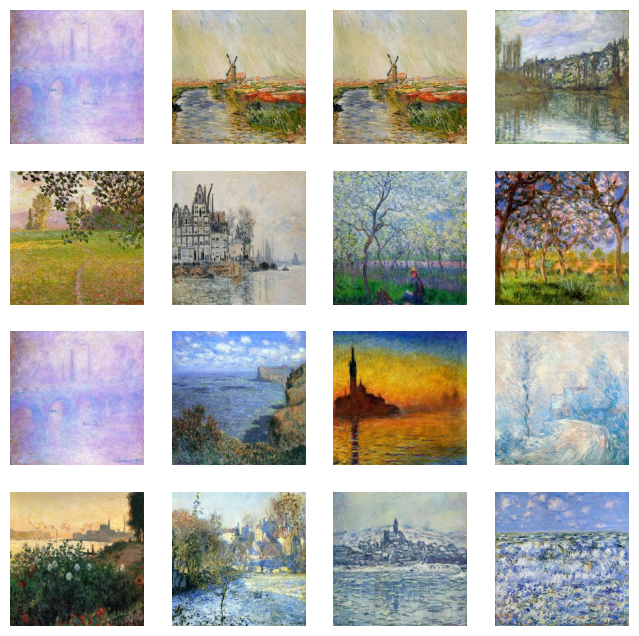

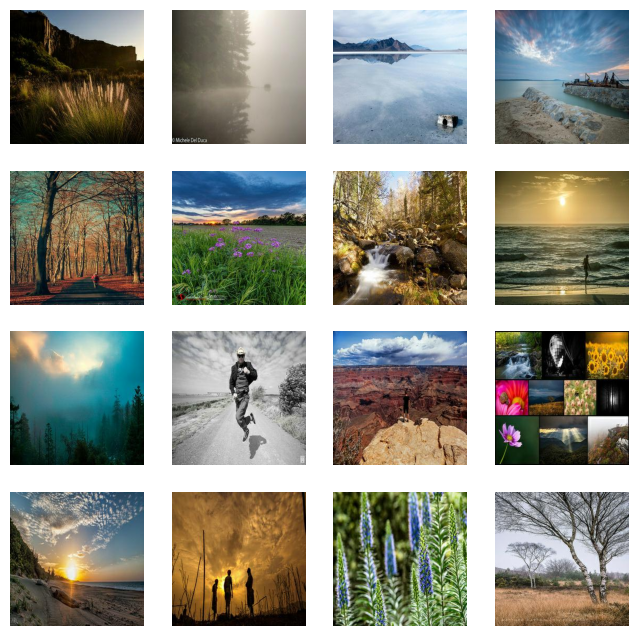

In [4]:
def display_sample_images(directory, n=4, cols=4):
    plt.figure(figsize=(8, 8))
    
    sample_size = n * cols
    
    files = np.random.choice(os.listdir(directory), sample_size)
    for i, file in enumerate(files):
        img = Image.open(os.path.join(directory, file))
        plt.subplot(n, cols, i+1)
        plt.imshow(img)
        plt.axis('off')
    
    plt.show()

# Display sample Monet paintings
display_sample_images(INPUT_PATH + '/monet_jpg')

# Display sample photos
display_sample_images(INPUT_PATH + '/photo_jpg')

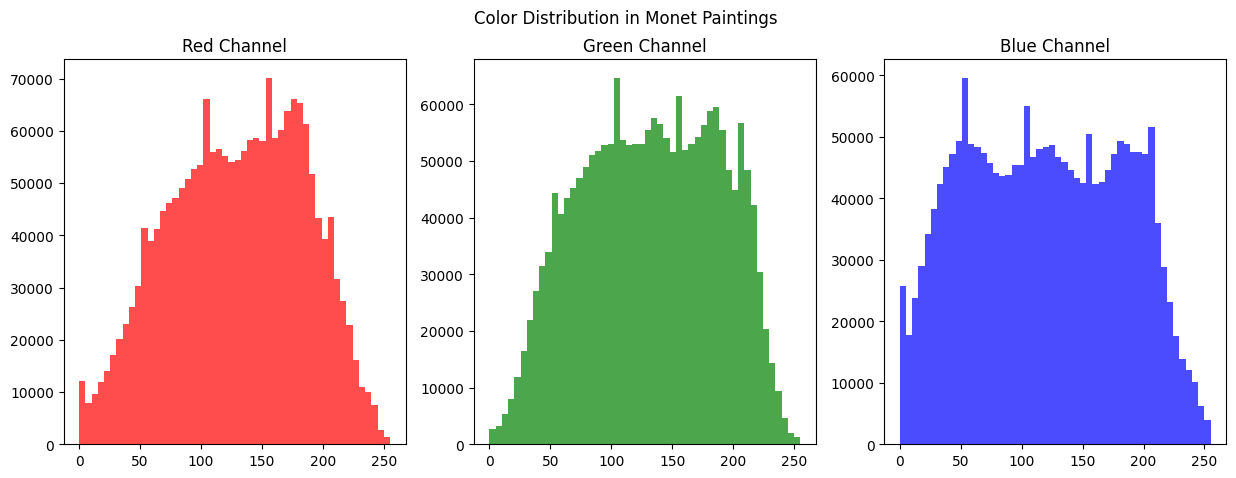

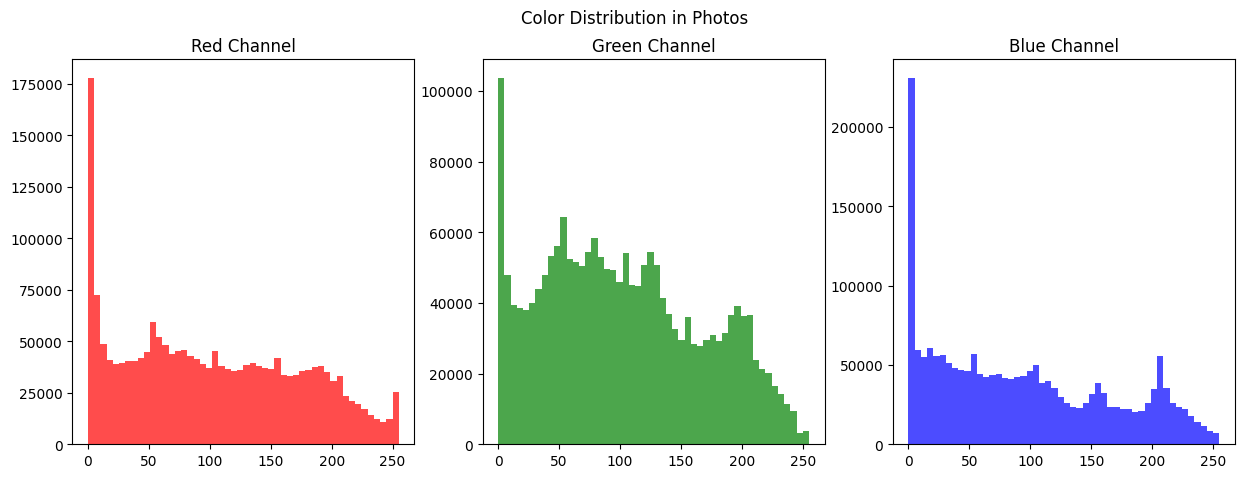

In [5]:
def analyze_color_distribution(directory, title):
    plt.figure(figsize=(15, 5))
    plt.suptitle(title)
    
    # Collect color data from 30 random images
    r_values, g_values, b_values = [], [], []
    files = np.random.choice(os.listdir(directory), 30)
    
    for file in files:
        img = np.array(Image.open(os.path.join(directory, file)))
        r_values.extend(img[:,:,0].flatten())
        g_values.extend(img[:,:,1].flatten())
        b_values.extend(img[:,:,2].flatten())
    
    # Plot RGB histograms
    plt.subplot(1, 3, 1)
    plt.hist(r_values, bins=50, color='red', alpha=0.7)
    plt.title('Red Channel')
    
    plt.subplot(1, 3, 2)
    plt.hist(g_values, bins=50, color='green', alpha=0.7)
    plt.title('Green Channel')
    
    plt.subplot(1, 3, 3)
    plt.hist(b_values, bins=50, color='blue', alpha=0.7)
    plt.title('Blue Channel')
    
    plt.show()

# Analyze Monet paintings
analyze_color_distribution(INPUT_PATH + '/monet_jpg', 'Color Distribution in Monet Paintings')

# Analyze photos (for comparison)
analyze_color_distribution(INPUT_PATH + '/photo_jpg', 'Color Distribution in Photos')

In [6]:
def compute_image_statistics(directory, sample_size=50):
    # Select random sample of images
    files = np.random.choice(os.listdir(directory), sample_size)
    
    brightness_values = []
    contrast_values = []
    saturation_values = []
    
    for file in files:
        img = np.array(Image.open(os.path.join(directory, file))) / 255.0
        
        # Calculate brightness (mean pixel value)
        brightness = np.mean(img)
        brightness_values.append(brightness)
        
        # Calculate contrast (standard deviation)
        contrast = np.std(img)
        contrast_values.append(contrast)
        
        # Calculate saturation
        r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
        saturation = np.mean(np.max(np.stack([r, g, b]), axis=0) - np.min(np.stack([r, g, b]), axis=0))
        saturation_values.append(saturation)
    
    return {
        'brightness': brightness_values,
        'contrast': contrast_values,
        'saturation': saturation_values
    }

# Compute statistics for both sets
monet_stats = compute_image_statistics(INPUT_PATH + '/monet_jpg')
photo_stats = compute_image_statistics(INPUT_PATH + '/photo_jpg')

C:\Users\aaron\AppData\Local\Temp\ipykernel_15772\275570763.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[i].boxplot([monet_stats[metric], photo_stats[metric]], labels=['Monet', 'Photos'])
C:\Users\aaron\AppData\Local\Temp\ipykernel_15772\275570763.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[i].boxplot([monet_stats[metric], photo_stats[metric]], labels=['Monet', 'Photos'])
C:\Users\aaron\AppData\Local\Temp\ipykernel_15772\275570763.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[i].boxplot([monet_stats[metric], photo_stats[metric]], labels=['Monet', 'Photos'])


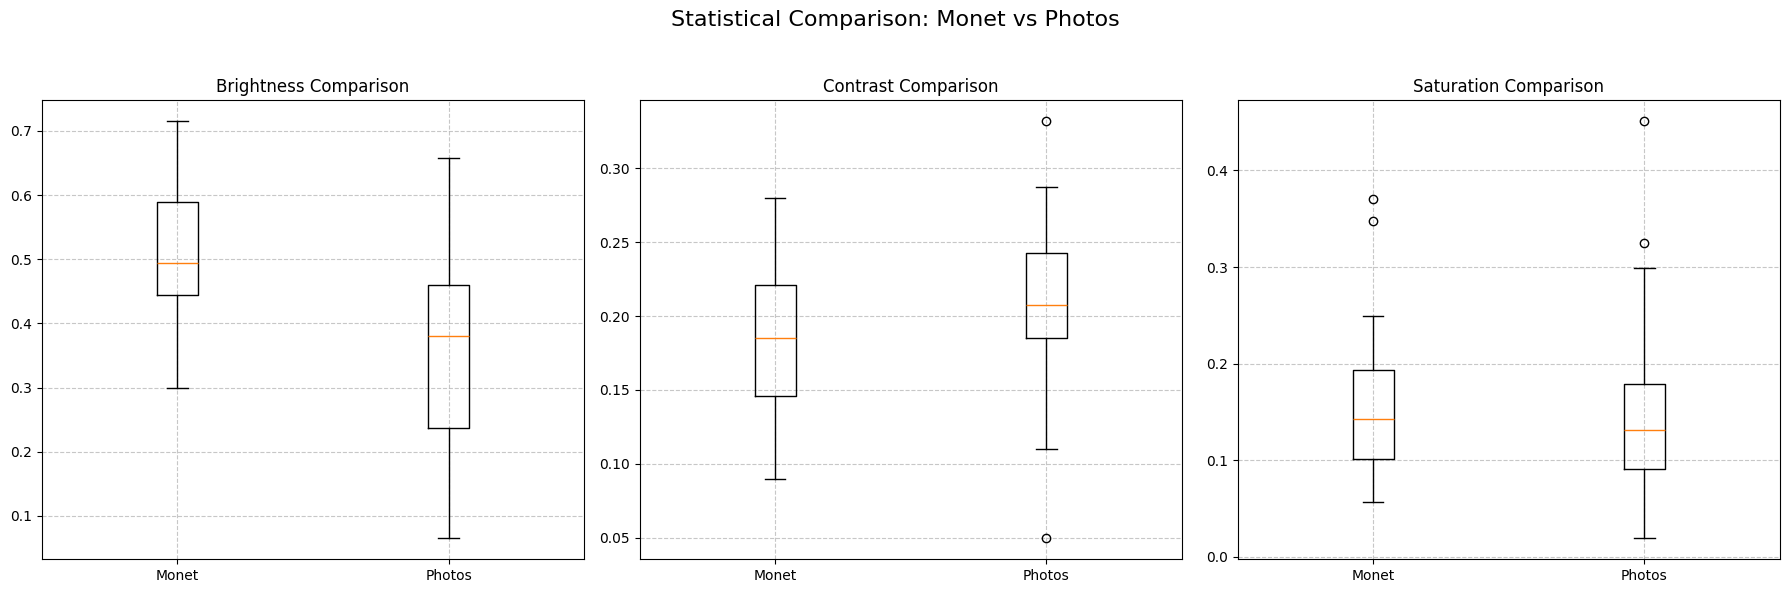

In [7]:
# Create comparison box plots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Statistical Comparison: Monet vs Photos', fontsize=16)

for i, metric in enumerate(['brightness', 'contrast', 'saturation']):
    axs[i].boxplot([monet_stats[metric], photo_stats[metric]], labels=['Monet', 'Photos'])
    axs[i].set_title(f'{metric.capitalize()} Comparison')
    axs[i].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

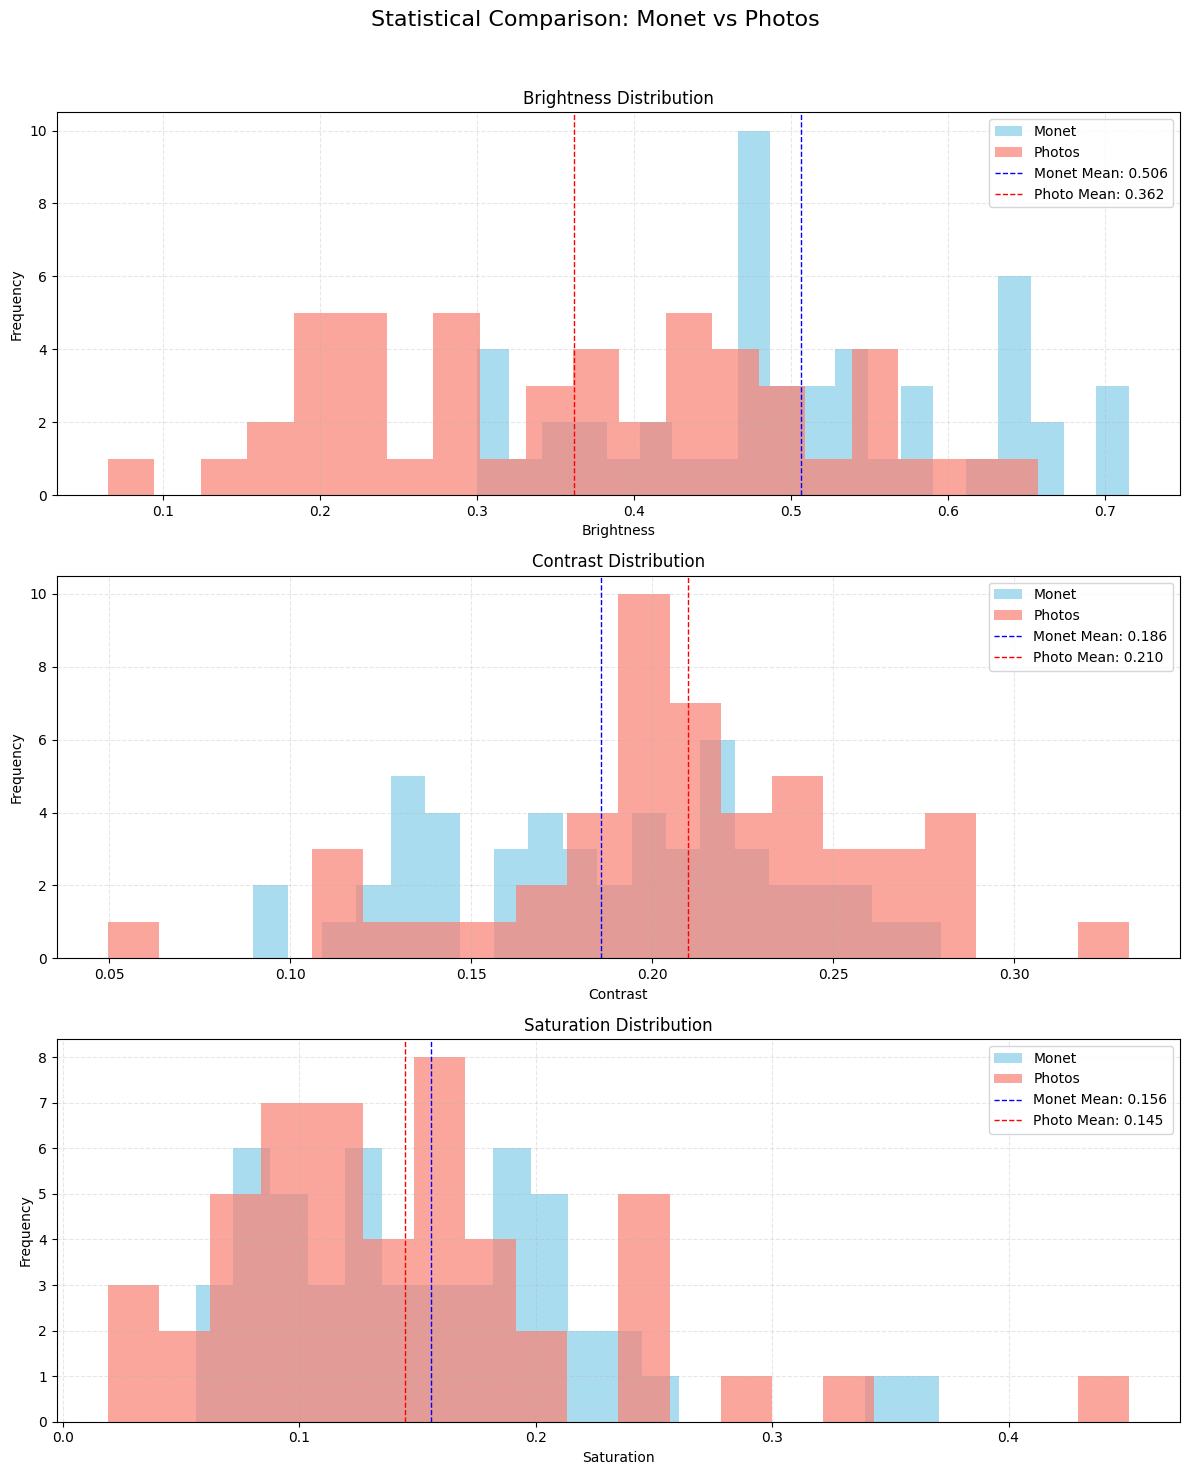

In [8]:
def plot_image_statistics_histograms(monet_stats, photo_stats):
    metrics = ['brightness', 'contrast', 'saturation']
    fig, axs = plt.subplots(3, 1, figsize=(12, 15))
    fig.suptitle('Statistical Comparison: Monet vs Photos', fontsize=16)
    
    for i, metric in enumerate(metrics):
        # Plot histograms on the same axis
        axs[i].hist(monet_stats[metric], bins=20, alpha=0.7, label='Monet', color='skyblue')
        axs[i].hist(photo_stats[metric], bins=20, alpha=0.7, label='Photos', color='salmon')
        
        # Add vertical lines for means
        monet_mean = np.mean(monet_stats[metric])
        photo_mean = np.mean(photo_stats[metric])
        axs[i].axvline(monet_mean, color='blue', linestyle='dashed', linewidth=1, label=f'Monet Mean: {monet_mean:.3f}')
        axs[i].axvline(photo_mean, color='red', linestyle='dashed', linewidth=1, label=f'Photo Mean: {photo_mean:.3f}')
        
        # Add labels and legend
        axs[i].set_title(f'{metric.capitalize()} Distribution')
        axs[i].set_xlabel(metric.capitalize())
        axs[i].set_ylabel('Frequency')
        axs[i].legend()
        axs[i].grid(True, linestyle='--', alpha=0.3)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Compute statistics if not already computed
if 'monet_stats' not in locals():
    monet_stats = compute_image_statistics(INPUT_PATH + '/monet_jpg')
    photo_stats = compute_image_statistics(INPUT_PATH + '/photo_jpg')

# Plot histograms
plot_image_statistics_histograms(monet_stats, photo_stats)

Analyzing Monet paintings: 100%|██████████| 100/100 [00:00<00:00, 700.03it/s]


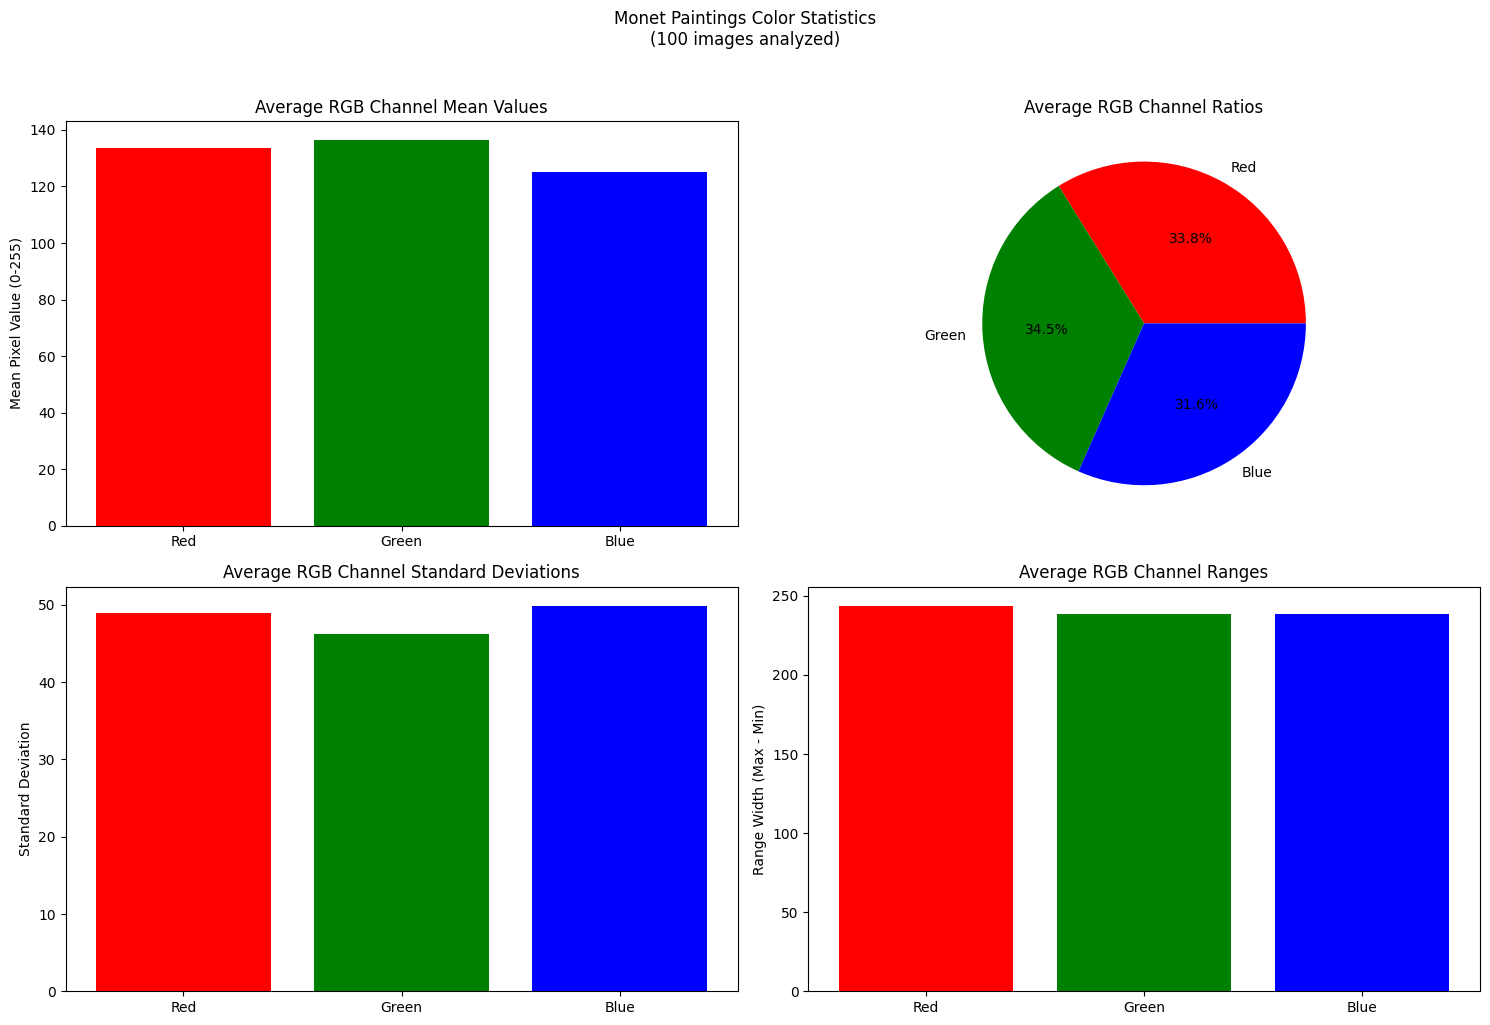

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm  # for progress bars

def analyze_rgb_dataset(dataset_path, sample_size=None, title=None):
    """
    Analyze color statistics from a Kaggle dataset.
    
    Args:
        dataset_path (str): Path to the directory containing Monet images
        sample_size (int, optional): Number of images to sample (None for all)
        
    Returns:
        dict: Aggregated color statistics across all analyzed images
        Displays matplotlib plots of the statistics
    """
    # Get list of Monet images
    monet_files = [f for f in os.listdir(dataset_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if sample_size and sample_size < len(monet_files):
        monet_files = np.random.choice(monet_files, sample_size, replace=False)
    
    # Initialize accumulators
    red_means, green_means, blue_means = [], [], []
    red_stds, green_stds, blue_stds = [], [], []
    red_mins, green_mins, blue_mins = [], [], []
    red_maxs, green_maxs, blue_maxs = [], [], []
    
    # Process each image
    for file in tqdm(monet_files, desc="Analyzing Monet paintings"):
        img_path = os.path.join(dataset_path, file)
        try:
            img = Image.open(img_path)
            img_array = np.array(img)
            
            # Remove alpha channel if present
            if img_array.shape[2] == 4:
                img_array = img_array[:, :, :3]
            
            # Extract channels
            red = img_array[:, :, 0].flatten()
            green = img_array[:, :, 1].flatten()
            blue = img_array[:, :, 2].flatten()
            
            # Accumulate stats
            red_means.append(np.mean(red))
            green_means.append(np.mean(green))
            blue_means.append(np.mean(blue))
            
            red_stds.append(np.std(red))
            green_stds.append(np.std(green))
            blue_stds.append(np.std(blue))
            
            red_mins.append(np.min(red))
            green_mins.append(np.min(green))
            blue_mins.append(np.min(blue))
            
            red_maxs.append(np.max(red))
            green_maxs.append(np.max(green))
            blue_maxs.append(np.max(blue))
            
        except Exception as e:
            print(f"Error processing {file}: {str(e)}")
            continue
    
    # Calculate aggregated statistics
    results = {
        'RGB_Mean_Values': {
            'Red': np.mean(red_means),
            'Green': np.mean(green_means),
            'Blue': np.mean(blue_means),
            'Channel_Ratios': {
                'Red': np.mean(red_means) / (np.mean(red_means) + np.mean(green_means) + np.mean(blue_means)),
                'Green': np.mean(green_means) / (np.mean(red_means) + np.mean(green_means) + np.mean(blue_means)),
                'Blue': np.mean(blue_means) / (np.mean(red_means) + np.mean(green_means) + np.mean(blue_means))
            }
        },
        'RGB_Standard_Deviations': {
            'Red': np.mean(red_stds),
            'Green': np.mean(green_stds),
            'Blue': np.mean(blue_stds),
            'Channel_Ranges': {
                'Red': (np.mean(red_mins), np.mean(red_maxs)),
                'Green': (np.mean(green_mins), np.mean(green_maxs)),
                'Blue': (np.mean(blue_mins), np.mean(blue_maxs))
            },
            'Average_Range_Width': {
                'Red': np.mean(np.array(red_maxs) - np.array(red_mins)),
                'Green': np.mean(np.array(green_maxs) - np.array(green_mins)),
                'Blue': np.mean(np.array(blue_maxs) - np.array(blue_mins))
            }
        },
        'Analysis_Metadata': {
            'Number_of_Images_Analyzed': len(red_means),
            'Dataset_Path': dataset_path
        }
    }
    
    # Create visualizations
    plt.figure(figsize=(15, 10))
    
    # 1. RGB Channel Means
    plt.subplot(2, 2, 1)
    channels = ['Red', 'Green', 'Blue']
    means = [results['RGB_Mean_Values']['Red'], 
             results['RGB_Mean_Values']['Green'], 
             results['RGB_Mean_Values']['Blue']]
    plt.bar(channels, means, color=['red', 'green', 'blue'])
    plt.title('Average RGB Channel Mean Values')
    plt.ylabel('Mean Pixel Value (0-255)')
    
    # 2. RGB Channel Ratios
    plt.subplot(2, 2, 2)
    ratios = [results['RGB_Mean_Values']['Channel_Ratios']['Red'],
              results['RGB_Mean_Values']['Channel_Ratios']['Green'],
              results['RGB_Mean_Values']['Channel_Ratios']['Blue']]
    plt.pie(ratios, labels=channels, colors=['red', 'green', 'blue'], autopct='%1.1f%%')
    plt.title('Average RGB Channel Ratios')
    
    # 3. RGB Standard Deviations
    plt.subplot(2, 2, 3)
    stds = [results['RGB_Standard_Deviations']['Red'],
            results['RGB_Standard_Deviations']['Green'],
            results['RGB_Standard_Deviations']['Blue']]
    plt.bar(channels, stds, color=['red', 'green', 'blue'])
    plt.title('Average RGB Channel Standard Deviations')
    plt.ylabel('Standard Deviation')
    
    # 4. RGB Channel Ranges
    plt.subplot(2, 2, 4)
    ranges = [results['RGB_Standard_Deviations']['Average_Range_Width']['Red'],
              results['RGB_Standard_Deviations']['Average_Range_Width']['Green'],
              results['RGB_Standard_Deviations']['Average_Range_Width']['Blue']]
    plt.bar(channels, ranges, color=['red', 'green', 'blue'])
    plt.title('Average RGB Channel Ranges')
    plt.ylabel('Range Width (Max - Min)')
    
    plt.suptitle(f"{title} Color Statistics\n({results['Analysis_Metadata']['Number_of_Images_Analyzed']} images analyzed)", y=1.02)
    plt.tight_layout()
    plt.show()
    
    return results

results_monet = analyze_rgb_dataset(INPUT_PATH + '/monet_jpg', sample_size=100, title='Monet Paintings')

Analyzing Monet paintings: 100%|██████████| 100/100 [00:00<00:00, 141.91it/s]


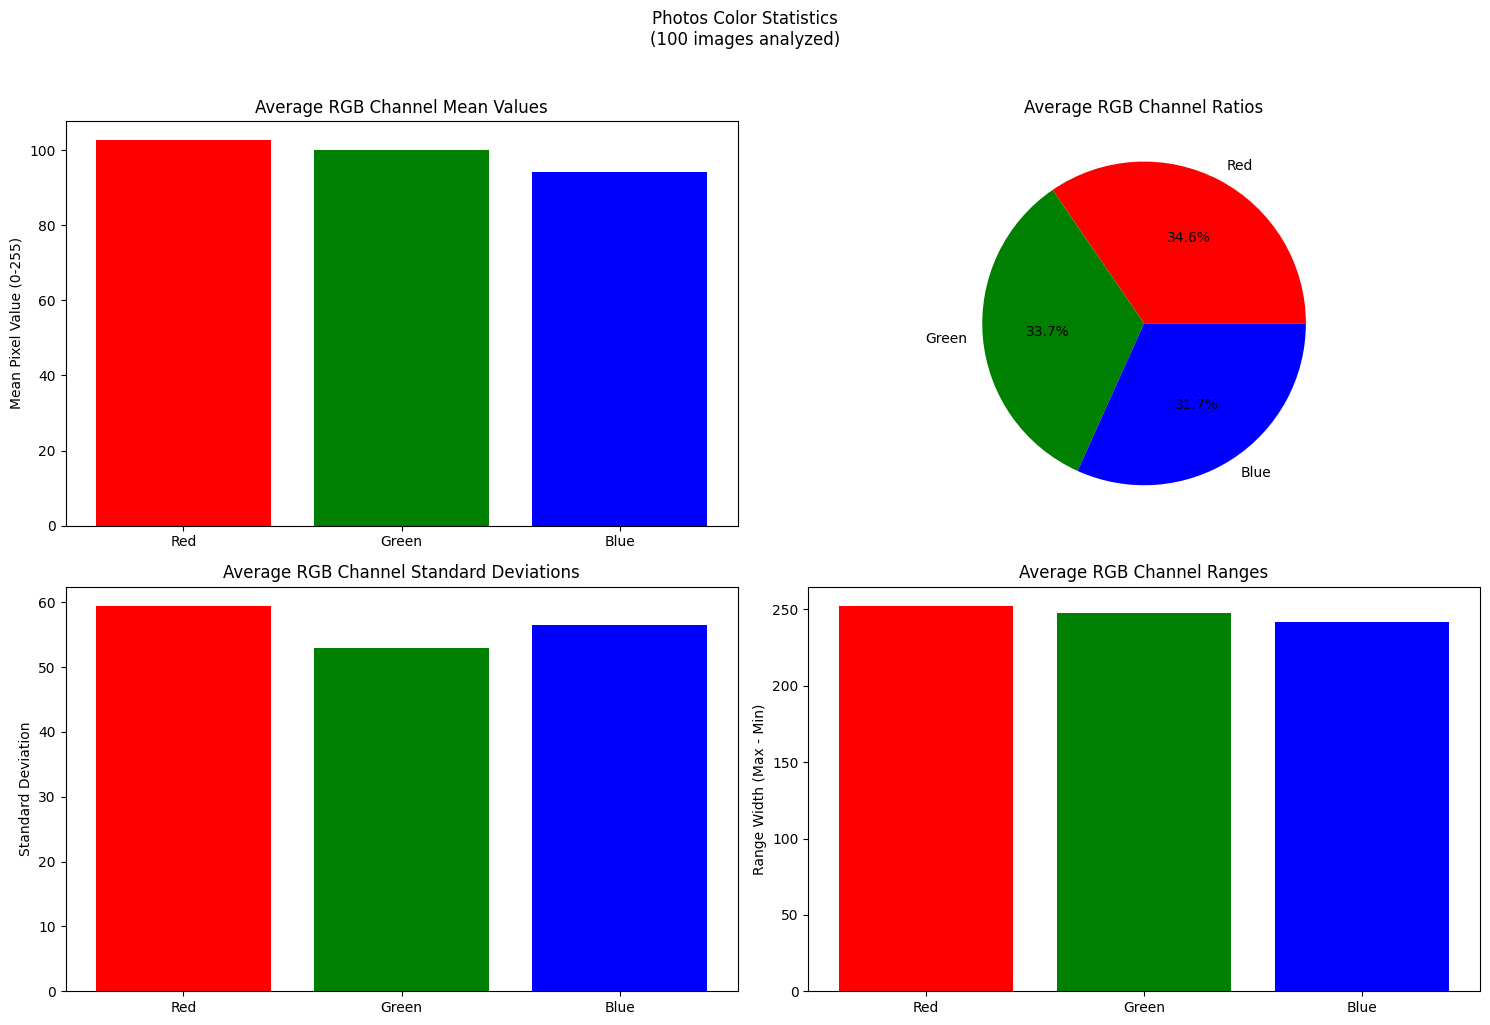

In [10]:
results_photo = analyze_rgb_dataset(INPUT_PATH + '/photo_jpg', sample_size=100, title='Photos')

In [11]:
def compute_rgb_statistics(directory, sample_size=1000):
    """
    Compute RGB statistics for images in a directory (similar structure to compute_image_statistics).
    
    Args:
        directory (str): Path to directory containing images
        sample_size (int): Number of images to sample
        
    Returns:
        dict: RGB statistics including means, std deviations, and ratios
    """
    # Select random sample of images
    files = np.random.choice([f for f in os.listdir(directory) if f.lower().endswith(('.jpg', '.jpeg', '.png'))], 
                            size=min(sample_size, len(os.listdir(directory))), 
                            replace=False)
    
    r_means, g_means, b_means = [], [], []
    r_stds, g_stds, b_stds = [], [], []
    r_ranges, g_ranges, b_ranges = [], [], []
    
    for file in files:
        try:
            img = np.array(Image.open(os.path.join(directory, file)))
            
            # Remove alpha channel if exists
            if img.shape[2] == 4:
                img = img[:, :, :3]
                
            # Normalize to 0-1
            img = img / 255.0
            
            # Split channels
            r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]
            
            # Calculate statistics per channel
            r_means.append(np.mean(r))
            g_means.append(np.mean(g))
            b_means.append(np.mean(b))
            
            r_stds.append(np.std(r))
            g_stds.append(np.std(g))
            b_stds.append(np.std(b))
            
            r_ranges.append(np.max(r) - np.min(r))
            g_ranges.append(np.max(g) - np.min(g))
            b_ranges.append(np.max(b) - np.min(b))
            
        except Exception as e:
            print(f"Error processing {file}: {str(e)}")
            continue
    
    # Calculate aggregated statistics
    return {
        'rgb_means': {
            'red': r_means,
            'green': g_means,
            'blue': b_means,
            'ratios': {
                'red': np.array(r_means) / (np.array(r_means) + np.array(g_means) + np.array(b_means)),
                'green': np.array(g_means) / (np.array(r_means) + np.array(g_means) + np.array(b_means)),
                'blue': np.array(b_means) / (np.array(r_means) + np.array(g_means) + np.array(b_means))
            }
        },
        'rgb_stds': {
            'red': r_stds,
            'green': g_stds,
            'blue': b_stds
        },
        'rgb_ranges': {
            'red': r_ranges,
            'green': g_ranges,
            'blue': b_ranges
        },
        'metadata': {
            'num_images_processed': len(r_means),
            'sample_size': sample_size
        }
    }

# Example usage (same as your original function)
monet_rgb_stats = compute_rgb_statistics(INPUT_PATH + '/monet_jpg')
photo_rgb_stats = compute_rgb_statistics(INPUT_PATH + '/photo_jpg')

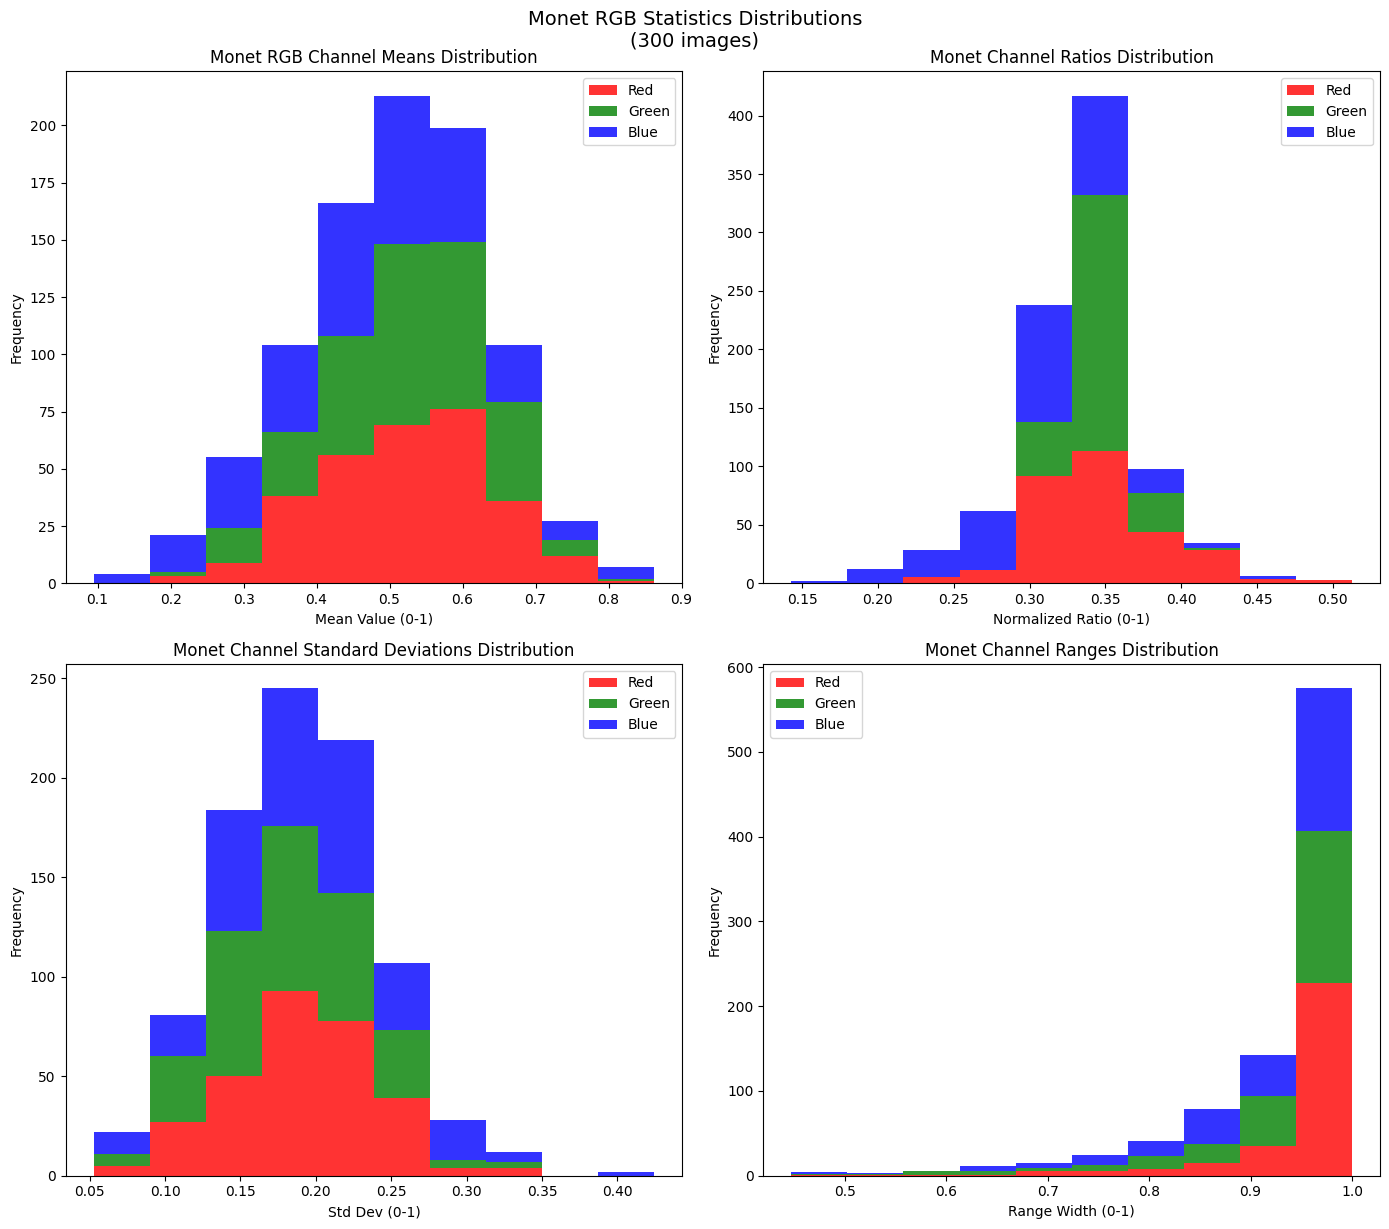

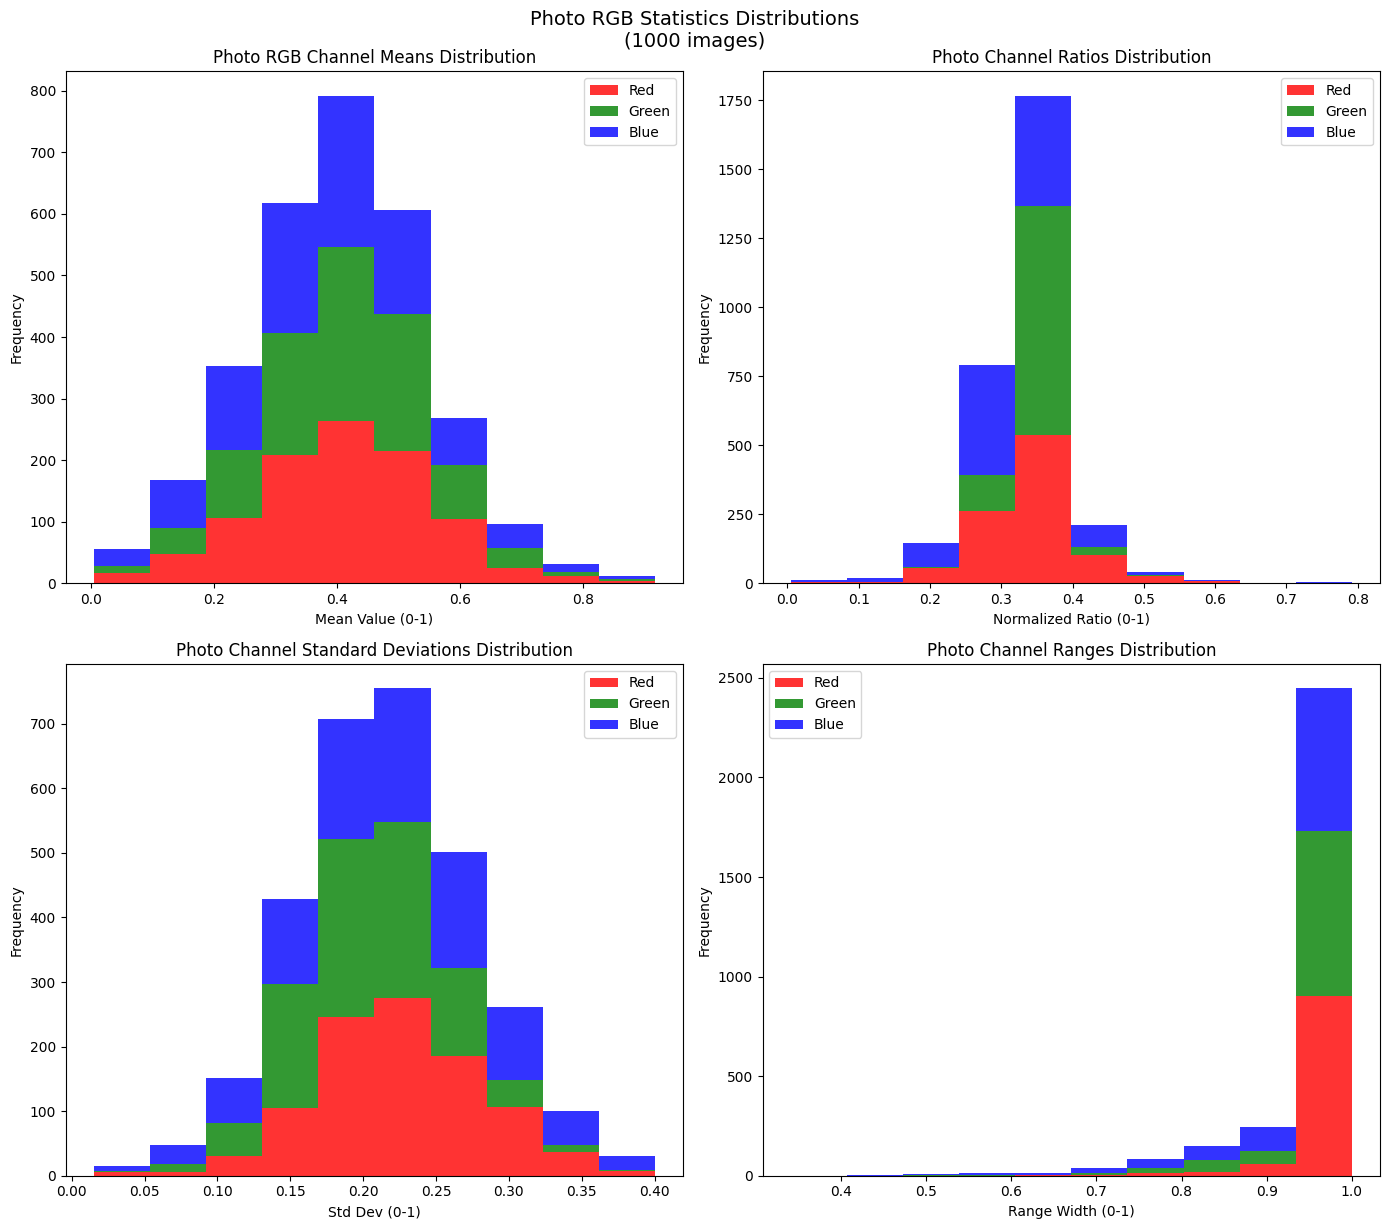

In [15]:
def plot_rgb_statistics_histograms(stats_dict, title_prefix=""):
    """
    Plot RGB statistics in a 2x2 grid using histograms with overlaid RGB channels.
    
    Args:
        stats_dict (dict): Output from compute_rgb_statistics function
        title_prefix (str): Prefix for plot titles (e.g., "Monet" or "Photo")
    """
    # Create 2x2 subplot grid
    fig, axs = plt.subplots(2, 2, figsize=(14, 12))
    axs = axs.flatten()  # Flatten for easy indexing
    
    # Extract data
    rgb_means = stats_dict['rgb_means']
    rgb_stds = stats_dict['rgb_stds']
    rgb_ranges = stats_dict['rgb_ranges']
    
    # Plot 1: Channel Means Distribution
    axs[0].hist([rgb_means['red'], rgb_means['green'], rgb_means['blue']],stacked=True,
                color=['red', 'green', 'blue'], alpha=0.8,
                label=['Red', 'Green', 'Blue'])
    axs[0].set_title(f'{title_prefix} RGB Channel Means Distribution')
    axs[0].set_xlabel('Mean Value (0-1)')
    axs[0].set_ylabel('Frequency')
    axs[0].legend()
    
    # Plot 2: Channel Ratios Distribution
    axs[1].hist([rgb_means['ratios']['red'], 
                 rgb_means['ratios']['green'], 
                 rgb_means['ratios']['blue']],stacked=True,
                color=['red', 'green', 'blue'], alpha=0.8,
                label=['Red', 'Green', 'Blue'])
    axs[1].set_title(f'{title_prefix} Channel Ratios Distribution')
    axs[1].set_xlabel('Normalized Ratio (0-1)')
    axs[1].set_ylabel('Frequency')
    axs[1].legend()
    
    # Plot 3: Standard Deviations Distribution
    axs[2].hist([rgb_stds['red'], rgb_stds['green'], rgb_stds['blue']],stacked=True,
                color=['red', 'green', 'blue'], alpha=0.8,
                label=['Red', 'Green', 'Blue'])
    axs[2].set_title(f'{title_prefix} Channel Standard Deviations Distribution')
    axs[2].set_xlabel('Std Dev (0-1)')
    axs[2].set_ylabel('Frequency')
    axs[2].legend()
    
    # Plot 4: Channel Ranges Distribution
    axs[3].hist([rgb_ranges['red'], rgb_ranges['green'], rgb_ranges['blue']],stacked=True,
                color=['red', 'green', 'blue'], alpha=0.8,
                label=['Red', 'Green', 'Blue'])
    axs[3].set_title(f'{title_prefix} Channel Ranges Distribution')
    axs[3].set_xlabel('Range Width (0-1)')
    axs[3].set_ylabel('Frequency')
    axs[3].legend()
    
    plt.tight_layout()
    plt.suptitle(f"{title_prefix} RGB Statistics Distributions\n({stats_dict['metadata']['num_images_processed']} images)", 
                 y=1.02, fontsize=14)
    plt.show()

# Example usage:
plot_rgb_statistics_histograms(monet_rgb_stats, "Monet")
plot_rgb_statistics_histograms(photo_rgb_stats, "Photo")

Dominant Colors in Monet Paintings:


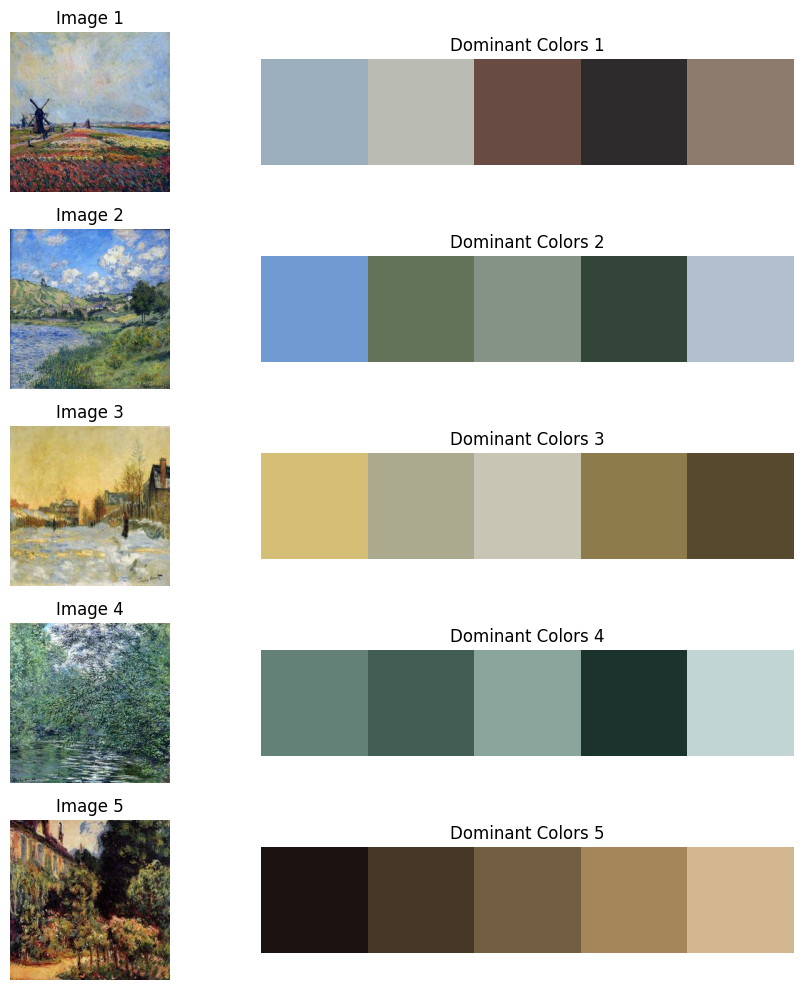

Dominant Colors in Photos:


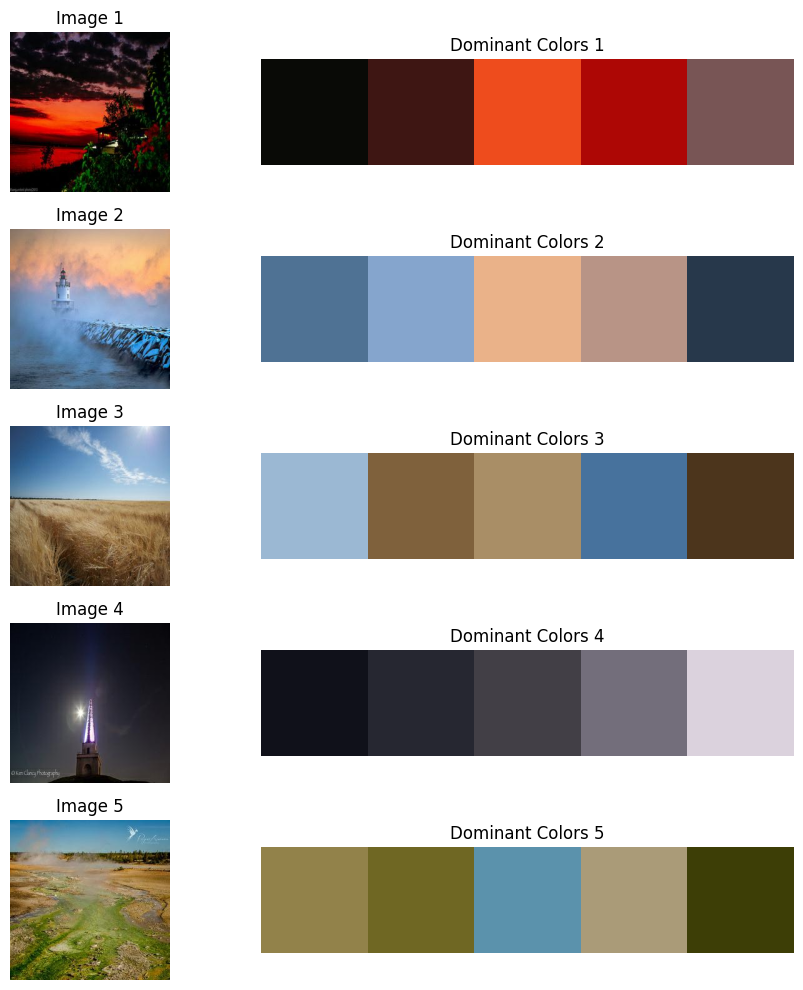

In [10]:
def extract_dominant_colors(directory, n_samples=5, n_colors=5):
    from sklearn.cluster import KMeans
    
    # Sample files
    all_files = os.listdir(directory)
    files = np.random.choice(all_files, min(n_samples, len(all_files)), replace=False)
    
    plt.figure(figsize=(10, 10))
    
    for i, file in enumerate(files):
        # Load image
        img_path = os.path.join(directory, file)
        img = np.array(Image.open(img_path))
        
        # Reshape for clustering
        pixels = img.reshape(-1, 3)
        
        # Apply KMeans to find dominant colors
        kmeans = KMeans(n_clusters=n_colors, n_init=10)
        kmeans.fit(pixels)
        colors = kmeans.cluster_centers_.astype(int)
        
        # Sort colors by occurrence (highest first)
        counts = np.bincount(kmeans.labels_)
        colors = colors[np.argsort(-counts)]
        
        # Display image
        plt.subplot(n_samples, 2, 2*i+1)
        plt.imshow(img)
        plt.title(f"Image {i+1}")
        plt.axis('off')
        
        # Display color palette
        plt.subplot(n_samples, 2, 2*i+2)
        plt.imshow([colors/255])
        plt.title(f"Dominant Colors {i+1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Extract dominant colors from Monet paintings
print("Dominant Colors in Monet Paintings:")
extract_dominant_colors(INPUT_PATH + '/monet_jpg')

# Extract dominant colors from photos
print("Dominant Colors in Photos:")
extract_dominant_colors(INPUT_PATH + '/photo_jpg')

# Prepare data

We'll use images from two directories: `monet` and `photo`. The `monet` directory contains paintings by Claude Monet, while the `photo` directory contains photographs of the same scenes. The goal is to train a neural network to transform a photograph into a Monet-style painting.


In [6]:
BATCH_SIZE = 8
IMAGE_SIZE = (256, 256) 
LATENT_DIM = 64
EPOCHS = 50

For this project, we will use the `tf.keras.preprocessing.image_dataset_from_directory` function to load the images from the directories. This function automatically labels the images based on the directory names and creates a dataset that can be used for training the model.

Additionally, we have to resize the images to a fixed size (256x256 pixels) and normalize the pixel values to be between -1 and 1. This is important for training GANs, as it helps stabilize the training process and improve the quality of the generated images.


In [7]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Laptop GPU, compute capability 8.6


In [8]:
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1.0
    return image

Shape of image: (256, 256, 3)


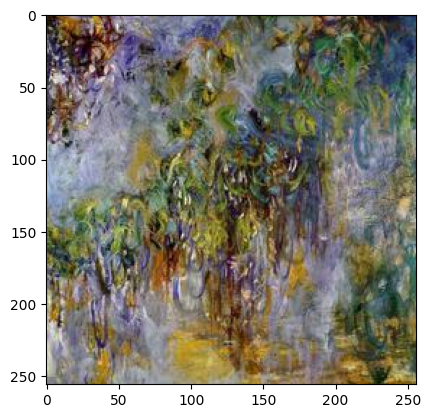

In [9]:
from matplotlib.image import imread
image = imread("../data/gan-getting-started/monet_jpg/0a5075d42a.jpg")
print("Shape of image:", image.shape)
plt.imshow(image)
plt.show()

In [10]:
dataset_monet = keras.utils.image_dataset_from_directory("../data/gan-getting-started/monet_jpg",label_mode=None, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE).map(preprocess).cache().prefetch(tf.data.AUTOTUNE)

Found 300 files belonging to 1 classes.


Shape of image: (256, 256, 3)


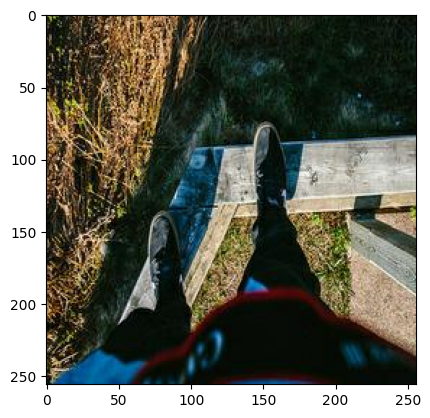

In [11]:
from matplotlib.image import imread
image = imread("../data/gan-getting-started/photo_jpg/00c6a0ad1e.jpg")
print("Shape of image:", image.shape)
plt.imshow(image)
plt.show()

In [12]:
dataset_photo = keras.utils.image_dataset_from_directory(
    "../data/gan-getting-started/photo_jpg",
    label_mode=None, 
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
).map(preprocess).cache().prefetch(tf.data.AUTOTUNE)

Found 7038 files belonging to 1 classes.


# Create the discriminator

The discriminator is a convolutional neural network (CNN) that classifies images as real or fake. It takes an image as input and outputs a probability that the image is real (from the dataset) or fake (generated by the generator). The discriminator is trained to maximize the probability of correctly classifying real and fake images.

In this case, the discriminator is a CNN with several convolutional layers, followed by spectral batch normalization and leaky ReLU activation functions. The final layer is a dense layer with a sigmoid activation function that outputs a probability between 0 and 1.

In [13]:
from tensorflow_addons.layers import SpectralNormalization

discriminator = models.Sequential([
    layers.Input(shape=(256, 256, 3)),
    SpectralNormalization(layers.Conv2D(64, kernel_size=4, strides=2, padding='same')),
    layers.LeakyReLU(alpha=0.2),
    SpectralNormalization(layers.Conv2D(16, kernel_size=4, strides=2, padding='same')),
    layers.LeakyReLU(alpha=0.2),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
], name="discriminator")
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spectral_normalization (Spe  (None, 128, 128, 64)     3200      
 ctralNormalization)                                             
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 spectral_normalization_1 (S  (None, 64, 64, 16)       16416     
 pectralNormalization)                                           
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 16)        0         
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dropout (Dropout)           (None, 65536)           

# Create the generator

The generator is a deep convolutional neural network (DCGAN) that takes a random noise vector as input and generates an image. The generator is trained to minimize the probability of the discriminator correctly classifying the generated image as fake. The generator and discriminator are trained together in an adversarial manner, where the generator tries to fool the discriminator while the discriminator tries to correctly classify real and fake images.

The generator is a DCGAN with several transposed convolutional layers and LeakyReLU activation functions. The final layer is a tanh activation function that outputs an image with pixel values between -1 and 1. The latent dimension is set to 16, which means the generator takes a random noise vector of size 16 as input. The generator is trained to generate images that resemble the paintings in the dataset.



In [14]:
LATENT_DIM = 16
generator = models.Sequential([
    layers.Input(shape=(LATENT_DIM,)),
    layers.Dense(64*64*LATENT_DIM),
    layers.Reshape((64, 64, LATENT_DIM)),
    layers.Conv2DTranspose(16, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(3, kernel_size=5, padding='same', activation='tanh')
], name='generator')
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 65536)             1114112   
                                                                 
 reshape (Reshape)           (None, 64, 64, 16)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 128, 128, 16)     4112      
 nspose)                                                         
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 128, 128, 16)      0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 256, 256, 64)     16448     
 ranspose)                                                       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 256, 256, 64)      0 

# Optimizers

The optimizers used for training the generator and discriminator are Adam optimizers with a learning rate of 0.0002 and beta_1 of 0.5. The learning rate is set to a low value to ensure stable training, and the beta_1 parameter is set to 0.5 to help with convergence.



In [15]:
# Optimizers
generator_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Training the GAN

The GAN is trained using the `train_step` function, which takes a batch of real images and a batch of random noise vectors as input. The function computes the loss for the discriminator and generator, updates their weights using the optimizers, and returns the losses.
The training process involves iterating over the dataset for a specified number of epochs, where each epoch consists of several steps. In each step, a batch of real images and a batch of random noise vectors are generated, and the `train_step` function is called to update the weights of the generator and discriminator.

# Loss functions

The loss function for the discriminator is the binary cross-entropy loss, which measures the difference between the predicted probabilities and the true labels (real or fake). The loss function for the generator is also the binary cross-entropy loss, but it is computed using the discriminator's predictions on the generated images. The generator tries to minimize this loss, while the discriminator tries to maximize it.

# Add noise

The augmentation function `add_noise` is used to add random noise to the images. This is done to improve the robustness of the model and prevent overfitting. The noise is added to the images before they are passed to the generator for training.



In [16]:
# Loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [17]:
def gradient_penalty(real_images, fake_images):
    alpha = tf.random.uniform([real_images.shape[0], 1, 1, 1], 0.0, 1.0)
    interpolated = alpha * real_images + (1 - alpha) * fake_images
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = discriminator(interpolated)
    grads = tape.gradient(pred, [interpolated])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    penalty = tf.reduce_mean((norm - 1.0) ** 2)
    return penalty

In [18]:
@tf.function
def add_noise_tf(images, noise_stddev):
    return images + tf.random.normal(shape=tf.shape(images), 
                                   mean=0.0, 
                                   stddev=noise_stddev)

In [19]:
import sys
@tf.function
def train_step(real_images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        # tf.print("gen_loss:", gen_loss, output_stream=sys.stdout)
        # tf.print("disc_loss:", disc_loss, output_stream=sys.stdout)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Process gradients to handle None and NaN values
    def safe_gradients(grads, vars):
        safe_grads = []
        for grad, var in zip(grads, vars):
            if grad is None:
                # Create zero gradient for None cases
                safe_grads.append(tf.zeros_like(var))
            else:
                # Replace NaN/inf values with zeros
                safe_grad = tf.where(
                    tf.math.logical_or(
                        tf.math.is_nan(grad),
                        tf.math.is_inf(grad)
                    ),
                    tf.zeros_like(grad),
                    grad
                )
                safe_grads.append(safe_grad)
        return safe_grads
    
    # Apply NaN protection
    safe_gen_grads = safe_gradients(gradients_of_generator, generator.trainable_variables)
    safe_disc_grads = safe_gradients(gradients_of_discriminator, discriminator.trainable_variables)

    # tf.print("gradients_of_generator:", gradients_of_generator, output_stream=sys.stdout)
    # tf.print("gradients_of_discriminator:", gradients_of_discriminator, output_stream=sys.stdout)

    generator_optimizer.apply_gradients(zip(safe_gen_grads, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(safe_disc_grads, discriminator.trainable_variables))

    return gen_loss, disc_loss
     

In [20]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    predictions = (predictions + 1.0) / 2.0  # Scale to [0, 1]
    predictions = tf.cast(predictions, tf.float32)  # Convert to float32
    fig = plt.figure(figsize=(10, 10))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :] * 0.5 + 0.5)
        plt.axis('off')
    plt.savefig(f"../images/image_at_epoch_{epoch:04d}.png")
    plt.close()

def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        print(f'Epoch {epoch + 1}, Gen Loss: {gen_loss.numpy()}, Disc Loss: {disc_loss.numpy()}')
        # Generate and save images every epoch
        latent_dim = LATENT_DIM
        seed = tf.random.normal([16, latent_dim])
        generate_and_save_images(generator, epoch + 1, seed)

    generator.save(f"../models/generator.keras")
    discriminator.save(f"../models/discriminator.keras")

In [21]:
latent_dim = LATENT_DIM
seed = tf.random.normal([16, latent_dim])
generate_and_save_images(generator, 10, seed)

In [22]:
# Entrenar el modelo
train(dataset_photo, EPOCHS)

Epoch 1, Gen Loss: 0.74072265625, Disc Loss: 0.9267578125
Epoch 2, Gen Loss: 1.431640625, Disc Loss: 0.37353515625
Epoch 3, Gen Loss: 2.142578125, Disc Loss: 0.324951171875
Epoch 4, Gen Loss: 2.11328125, Disc Loss: 0.28369140625
Epoch 5, Gen Loss: 1.8134765625, Disc Loss: 0.4326171875
Epoch 6, Gen Loss: 2.33203125, Disc Loss: 0.9326171875
Epoch 7, Gen Loss: 1.3984375, Disc Loss: 0.89453125
Epoch 8, Gen Loss: 1.3173828125, Disc Loss: 1.0927734375
Epoch 9, Gen Loss: 1.828125, Disc Loss: 0.57568359375
Epoch 10, Gen Loss: 0.939453125, Disc Loss: 0.81396484375
Epoch 11, Gen Loss: 1.353515625, Disc Loss: 0.66796875
Epoch 12, Gen Loss: 1.4345703125, Disc Loss: 1.2109375
Epoch 13, Gen Loss: 2.232421875, Disc Loss: 0.900390625
Epoch 14, Gen Loss: 2.06640625, Disc Loss: 0.7568359375
Epoch 15, Gen Loss: 1.2783203125, Disc Loss: 1.0703125
Epoch 16, Gen Loss: 1.8037109375, Disc Loss: 1.033203125
Epoch 17, Gen Loss: 2.185546875, Disc Loss: 1.0390625
Epoch 18, Gen Loss: 1.2578125, Disc Loss: 0.689453

# Example of using the GAN

After training the GAN, we can use it to generate new images of paintings. The `generate_images` function takes a batch of random noise vectors as input and generates images using the generator. The generated images can be saved to disk or displayed using matplotlib.

(256, 256, 3)
[[[ 61  88 100]
  [ 51  82 108]
  [ 60  89 122]
  ...
  [ 23  24  28]
  [ 28  30  33]
  [ 45  55  57]]

 [[ 58  92 111]
  [ 51  85 115]
  [ 51  83 120]
  ...
  [ 28  34  39]
  [ 18  19  22]
  [ 28  35  32]]

 [[ 58  98 120]
  [ 50  85 125]
  [ 55  88 123]
  ...
  [ 16  19  21]
  [ 14  20  14]
  [ 21  27  22]]

 ...

 [[  0   0   0]
  [  1   1   0]
  [  4   5   5]
  ...
  [ 13  13   7]
  [  7   7   3]
  [ 14  14   9]]

 [[  0   0   0]
  [  1   1   0]
  [  3   3   2]
  ...
  [ 11  11   6]
  [  9  12   5]
  [ 15  17  12]]

 [[  5   5   3]
  [  3   6   2]
  [  7   8   6]
  ...
  [ 15  19  11]
  [ 15  18   9]
  [ 23  28  21]]]


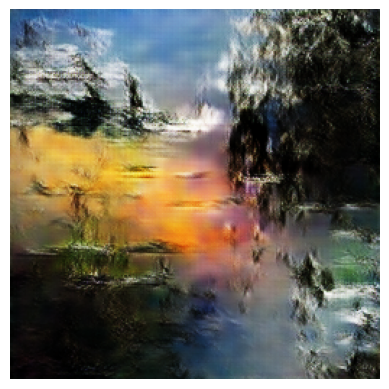

In [23]:
noise = tf.random.normal([1, latent_dim])
image = generator(noise)[0].numpy()
image = (image * 127.5 + 127.5).astype(np.uint8)
print(image.shape)
print(image)
plt.imshow(image)
plt.axis('off')
plt.show()

In [26]:
# Submission

import os
import zipfile
from tqdm import tqdm
import cv2

# Configurations
num_images = 7000

with zipfile.ZipFile('images.zip', 'w') as zipf:
    for i in tqdm(range(num_images)):
        # 1. Generar imagen
        noise = tf.random.normal([1, LATENT_DIM])
        image = generator(noise)[0].numpy()
        
        # 2. Convertir a formato JPG en memoria
        image = (image * 127.5 + 127.5).astype(np.uint8)
        is_success, buffer = cv2.imencode(".jpg", cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        
        # 3. Escribir directamente al ZIP
        zipf.writestr(f"image_{i}.jpg", buffer)

100%|██████████| 7000/7000 [01:21<00:00, 85.61it/s]


# Conclusions

In this mini project, we implemented a GAN model to generate images of paintings using the "I’m Something of a Painter Myself" dataset. The model was trained using TensorFlow and Keras, and the generated images can be used for various purposes, such as art generation and style transfer.

tHE project demonstrates the power of GANs in generating realistic images and highlights the potential applications of this technology in the field of art and creativity.

We have some difficulties in training the GAN model, such as mode collapse and instability during training. These issues can be addressed by using techniques such as progressive growing of GANs, spectral normalization, and improved loss functions. Additionally, we can experiment with different architectures and hyperparameters to improve the quality of the generated images.

Additionally, we need to deal with the problem of OOM (Out of Memory) errors when training the model. This can be done by reducing the batch size, using mixed precision training, or using a smaller model architecture. We can also use gradient checkpointing to save memory during training.

